<a href="https://colab.research.google.com/github/OjasKhandelwal/LearnML/blob/main/CNN_using_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.optim as optim

In [4]:
#set random seeds for reproductibilty
torch.manual_seed(42)

In [5]:
df = pd.read_csv('/content/fashion-mnist_train.csv')
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6,0,0,0,0,0,0,0,5,0,...,0.0,0.0,0.0,30.0,43.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,1,2,0,0,0,0,...,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,3,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
#train test split

x = df.iloc[: , 1:].values
y = df.iloc[: , 0].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

#scaling the features
x_train =  x_train/255.0
x_test =  x_test/255.0

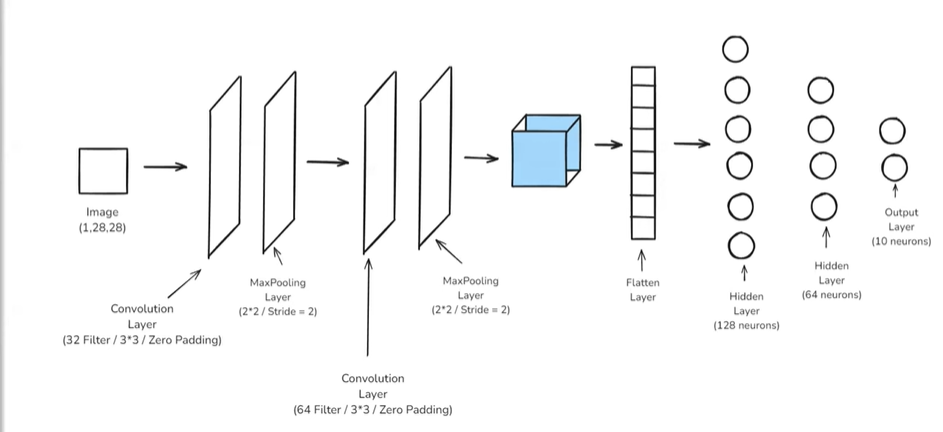

In [7]:
#create CustomDataset class

class CustomDataset(Dataset):
  def __init__(self , features ,labels):
    self.features  = torch.tensor(features , dtype=torch.float32).reshape(-1,1,28,28)
    self.labels = torch.tensor(labels , dtype=torch.long)

  def __len__(self):
    return len(self.features)


  def __getitem__(self , index):
    return self.features[index] , self.labels[index]


In [8]:
#create train_dataset object
train_dataset = CustomDataset(x_train , y_train)

#test_dataset object
test_dataset = CustomDataset(x_test , y_test)

#create train & test loader
train_loader = DataLoader(train_dataset , batch_size=32 , shuffle=True)
test_loader = DataLoader(test_dataset , batch_size=32 , shuffle=False)

In [10]:
#create nn class

class MyNN(nn.Module):
  def __init__(self , num_features):
    super().__init__()

    self.features = nn.Sequential(
        nn.Conv2d(in_channels=1 , out_channels=32 , kernel_size=3 , stride=1 , padding='same'),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(kernel_size=2 , stride=2),

        nn.Conv2d(in_channels=32 , out_channels=64 , kernel_size=3 , stride=1 , padding='same'),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(kernel_size=2 , stride=2),
    )


    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=64*7*7 , out_features=128),
        nn.ReLU(),
        nn.Dropout(0.4),

        nn.Linear(128 ,64),
        nn.ReLU(),
        nn.Dropout(0.4),

        nn.Linear(64 ,10),


    )



  def forward(self , x):
    x = self.features(x)
    x = self.classifier(x)

    return x

In [11]:
#set learning rate & epochs
epochs = 100
learning_rate = 0.1

#instantiate the model
model = MyNN(1)

#loss function
loss_fn = nn.CrossEntropyLoss()

#optimizer
optimizer = optim.SGD(model.parameters() , lr=learning_rate , weight_decay=1e-4)

In [14]:
#training loop

for epoch in range(epochs):
  for batch_features , batch_labels in train_loader:

    #forward pass
    outputs = model(batch_features)

    #calculate loss
    loss = loss_fn(outputs , batch_labels)

    #backward pass
    optimizer.zero_grad()
    loss.backward()

    #update weights
    optimizer.step()


In [15]:
model.eval()

MyNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.4, inplace=False)
    (7): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [16]:
#evaluation code

total = 0
correct = 0

with torch.no_grad():
  for batch_features , batch_labels in test_loader:
    outputs = model(batch_features)
    _, predicted = torch.max(outputs , 1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()


print(correct/total)

0.8912354804646251
